# Relax Challenge

In this practice takehome challenge, you are given two datasets: 

1. takehome_users.csv: data on 12,000 users who signed up for the product in the last two years, including name, email, user ID, account creation source (guest invite, org invite, sign-up, sign-up through Google authorization, and personal projects), account creation time, most recent session time, opted into mailing list, enabled marketing drip, org ID, and user ID of invitee.
2. takehome_user_engagement.csv: a usage summary table that has a row for each day that a user logged into the product.


An "adopted user" is defined as a user who has logged into the product on three separate days in at least one seven-day period. Identify which factors predict future user adoption.

## Set-up

Import relevant libraries

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

#style elements, hide warnings
import warnings
warnings.simplefilter('ignore')
plt.style.use('ggplot')


print('done')

done


Read in the "takehome_users" csv file. First time resulted in an encoding error, so encoding is specified. The user ID column is also called "object_id," so we will rename this.

In [2]:
#read csv 1
df_users = pd.read_csv('takehome_users.csv', encoding='latin-1')
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
#rename object id column to user id
df_users = df_users.rename(columns={"object_id": "user_id"})

#check length of df
print(max(df_users['user_id']))

12000


Next read in the "takehome_user_engagement" csv file. We will check how long it is and how many user IDs are represented, as well as check for null values that may need taking care of. We see that the users df has nulls in the last session column, as well as in the invited by user ID column, most likely representing users who were not invited by someone to sign up for the platform, and instead signed up on their own or through other means.

In [4]:
#read csv
df_user_engagement = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])
df_user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
#number of users from users df
print(len(df_users))

#number of total logins from user engagement df
print(len(df_user_engagement))

#max ID number represented in user engagement df
print(max(df_user_engagement['user_id']))

12000
207917
12000


In [6]:
#check for nulls in both dfs
print(df_users.isnull().sum())
print(df_user_engagement.isnull().sum())

#two columns with nulls

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64
time_stamp    0
user_id       0
visited       0
dtype: int64


## Data Cleaning

The first wrangling step is to find out which user IDs logged in at least three times over any seven day period using the user engagement df. These will be the users who are considered "adopted" and will form the class column for predictive modeling later. 

First we will double check and drop duplicates, since logging in twice in one day does not count towards the three separate login days in the seven-day period. A previous check using the datetime .dt.floor('d') showed that no days were repeated in the dataset for each unique user ID.

In [7]:
#double check drop duplicates, length does not change
df_user_engagement = df_user_engagement.drop_duplicates()
print(len(df_user_engagement))

207917


Next we can eliminate all users with less than three logins. Since to be considered an adopted user, you need three logins in the period, any user that does not have three logins total cannot meet that requirement. When we check the length, we see it has eliminated almost 7000 rows.

In [8]:
#filter out ids that have less than 3 logins
df_3_logins = df_user_engagement.groupby('user_id').filter(lambda x: len(x) > 2)
df_3_logins.head()

,time_stamp,user_id,visited
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1


In [9]:
#check length
len(df_3_logins)

201002

To make it a bit neater for the rolling method later, we will eliminate the time portion of the datetime column. Then we set the time stamp as index and sort according to date.

In [10]:
#drop times from datetime
df_3_logins['time_stamp'] = df_3_logins['time_stamp'].dt.floor('d')
df_3_logins.head()

,time_stamp,user_id,visited
1,2013-11-15,2,1
2,2013-11-29,2,1
3,2013-12-09,2,1
4,2013-12-25,2,1
5,2013-12-31,2,1


In [11]:
#set timestamp as index
date_index = df_3_logins.set_index('time_stamp')
date_index.head()

,user_id,visited
time_stamp,,
2013-11-15,2,1
2013-11-29,2,1
2013-12-09,2,1
2013-12-25,2,1
2013-12-31,2,1


In [12]:
#sort date index
df_sorted = date_index.sort_index()
df_sorted.head()

,user_id,visited
time_stamp,,
2012-05-31,1693,1
2012-05-31,3428,1
2012-06-01,8068,1
2012-06-02,7170,1
2012-06-02,3514,1


Using pandas rolling method, we can generate a df of accumulated visits over every seven-day period. Grouped by user, the rolling method then takes each date present and looks back in a specified timeframe (here 7D) and counts the number of occurences.

In [13]:
#grouped by user ID, count visits in seven-day rolling windows
_grouped = df_sorted.groupby("user_id").rolling('7D').visited.count()

#set as new df
df_7d_count = pd.DataFrame(_grouped)
df_7d_count = df_7d_count.rename(columns={"Amount":"visits_per_7D"})
df_7d_count.head()

visited
user_id time_stamp         
2       2013-11-15      1.0
        2013-11-29      1.0
        2013-12-09      1.0
        2013-12-25      1.0
        2013-12-31      2.0

In [14]:
#look a little further
df_7d_count.head(20)

#the threes in the df do in fact have three logins within the past seven days

visited
user_id time_stamp         
2       2013-11-15      1.0
        2013-11-29      1.0
        2013-12-09      1.0
        2013-12-25      1.0
        2013-12-31      2.0
        2014-01-08      1.0
        2014-02-03      1.0
        2014-02-08      2.0
        2014-02-09      3.0
        2014-02-13      3.0
        2014-02-16      2.0
        2014-03-09      1.0
        2014-03-13      2.0
        2014-03-31      1.0
10      2013-01-16      1.0
        2013-01-22      2.0
        2013-01-30      1.0
        2013-02-04      2.0
        2013-02-06      2.0
        2013-02-14      1.0

We can filter again to get only rows with 3 visits. 

In [15]:
#filter for 3 visits
df_adopted = df_7d_count.loc[df_7d_count['visited'] > 2]
df_adopted.head()

visited
user_id time_stamp         
2       2014-02-09      3.0
        2014-02-13      3.0
10      2013-02-19      3.0
        2013-03-02      3.0
        2013-03-05      3.0

In [16]:
len(df_adopted)

160522

Next we create can look at the user_id multi-index to see which users met the criteria to be considered adopted and save this as a list.

In [17]:
#save IDs from index
adopted_ids = df_adopted.index.levels[0]

In [18]:
#preview
adopted_ids

Int64Index([    2,    10,    20,    33,    42,    43,    50,    53,    59,
               60,
            ...
            11961, 11964, 11965, 11967, 11969, 11975, 11980, 11981, 11988,
            11991],
           dtype='int64', name='user_id', length=2248)

In [19]:
#check how many IDs
len(adopted_ids)

2248

In [20]:
#save as list
adopted_list = list(adopted_ids)
adopted_list[:5]

[2, 10, 20, 33, 42]

Going to back the users df, we can create our classification column by matching values in the user ID column with items in the adopted users list.

In [21]:
#match items from list to create boolean column
df_users['adopted'] = df_users['user_id'].isin(adopted_list)
df_users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False


In [22]:
#change to integers 0 and 1
df_users['adopted'] = df_users['adopted'].astype(int)
df_users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


Now we will fill in some NaNs. For the invited by user ID column, we will fill blanks with 0, because these users were not invited by another user.

In [23]:
#check nulls once more
print(df_users.isnull().sum())

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted                          0
dtype: int64


In [24]:
#fill nulls with 0
df_users['invited_by_user_id'] = df_users['invited_by_user_id'].fillna(0)
df_users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


We can also add some features to the data. For example, the email column is not very useful because each email is (presumably) unique, but domains might be more informative. We can split this column into email name and domain.

In [25]:
#split emails on @ to extract domain
df_users[['email', 'domain']] = df_users['email'].str.split('@', expand=True)
df_users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,domain
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,yahoo.com
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,gustr.com
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,gustr.com
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0,yahoo.com
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0,yahoo.com


Likewise, we can create a column of active user time by calculating the difference between the account creation time and the most recent login. First we change the last session time and creation times to datetime format, then we compute the difference and save it as days in a new column.

In [26]:
#change last session time to datetime (from unix time)
df_users['last_session_creation_time'] = pd.to_datetime(df_users['last_session_creation_time'], unit='s')
df_users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,domain
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,yahoo.com
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,gustr.com
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,gustr.com
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,yahoo.com
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,yahoo.com


In [27]:
#change creation time to datetime
df_users['creation_time'] = pd.to_datetime(df_users['creation_time'])

In [28]:
#calculate difference in days between two columns
df_users['member_days'] = df_users['last_session_creation_time'] - df_users['creation_time']
df_users['member_days'] = df_users['member_days'].dt.days
df_users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,domain,member_days
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,yahoo.com,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,gustr.com,136.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,gustr.com,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,yahoo.com,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,yahoo.com,5.0


Just take a quick look to see if there are repeated individuals. (Fake accounts??)

In [29]:
df_users.name.value_counts()

Cavalcanti Victor    5
Araujo Gabriela      5
Correia Leonardo     4
Souza Fernanda       4
Azevedo Clara        4
                    ..
Howitt Aidan         1
Zimmer Barbara       1
Lind Oskar           1
Baader Dirk          1
Alexander Naomi      1
Name: name, Length: 11355, dtype: int64

Next we look at the df statistics and balance between the two classes in order to decide how to handle the nulls in the last session creation time. As we see from the most recent df head printout, user 1 has the same date/time for the creation of their account as they do for the last session time. Because of this we can infer that the nulls in this column do not necessarily represent users who logged in only once for account creation and then never logged in again. If possible, we probably don't want to use these, because they may be errors.

In [30]:
#check stats
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  float64       
 10  adopted                     12000 non-null  int64         
 11  domain                      12000 non-null  object    

In [31]:
#check how the nulls are distributed in the adopted category.
df_users.loc[df_users.last_session_creation_time.isna()]['adopted'].value_counts()

#all nulls appear in the non-adopted category!

0    3177
Name: adopted, dtype: int64

In [32]:
#check distribution of classes
#0=not adopted, 1=adopted
df_users.adopted.value_counts()

0    9752
1    2248
Name: adopted, dtype: int64

We can see that the two classes are very unbalanced, with over 4x the number of unadopted users as there are adopted users. To balance the data, we will randomly sample 2248 rows from the 0 category to match the 1 category. Since all the nulls fortunately appear in the 0 category, and even without them we would still need to sample due to imbalance in favor the 0 category, we can filter these out and then sample from the remaining complete data. Null problem solved!

In [33]:
#all nans are in 0 category, and we need to only take a sample of these to balance the data, so we can drop them
df_noNaN = df_users.dropna()

#recheck distribution after dropping null
df_noNaN.adopted.value_counts()

0    6575
1    2248
Name: adopted, dtype: int64

In [34]:
#randomly sample 2248 non-NaN rows from the non-adopted users (0) to balance the data

df_adopted_0 = df_noNaN[df_noNaN['adopted']==0]
df_adopted_1 = df_noNaN[df_noNaN['adopted']==1]


df_adopted_0_samples = df_adopted_0.sample(n=len(df_adopted_1), random_state=42)

#check counts
print(len(df_adopted_0))
print(len(df_adopted_1))
print(len(df_adopted_0_samples))

6575
2248
2248


In [35]:
#check distribution of categories in balanced dataset
df_ml = df_adopted_1.append(df_adopted_0_samples)
df_ml.adopted.value_counts()

1    2248
0    2248
Name: adopted, dtype: int64

In [36]:
#it's not a lot of data, but let's try
#recheck stats
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4496 entries, 1 to 10775
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     4496 non-null   int64         
 1   creation_time               4496 non-null   datetime64[ns]
 2   name                        4496 non-null   object        
 3   email                       4496 non-null   object        
 4   creation_source             4496 non-null   object        
 5   last_session_creation_time  4496 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    4496 non-null   int64         
 7   enabled_for_marketing_drip  4496 non-null   int64         
 8   org_id                      4496 non-null   int64         
 9   invited_by_user_id          4496 non-null   float64       
 10  adopted                     4496 non-null   int64         
 11  domain                      4496 non-null   object     

## Prepare data for predictive modeling

Our dataset is rather small now, but we will still try to work with it. Next we need to prepare the data for machine learning by changing everything to numeric values. Here I split datetimes into year, month, day, day of week, and hour. I also drop the unhelpful columns name, email, user ID, creation time, and last session time, due to having all or mostly unique values, or being repetitive from the datetime split. For the categorical columns domain and creation source, these are one-hot encoded with the pandas get dummies function.

In [37]:
#make everything numeric, drop unhelpful columns

#split datetime columns
df_ml['creation_year'] = df_ml['creation_time'].dt.year
df_ml['creation_month'] = df_ml['creation_time'].dt.month
df_ml['creation_day'] = df_ml['creation_time'].dt.day
df_ml['creation_dayofweek'] = df_ml['creation_time'].dt.dayofweek
df_ml['creation_hour'] = df_ml['creation_time'].dt.hour

df_ml['last_sess_year'] = df_ml['last_session_creation_time'].dt.year
df_ml['last_sess_month'] = df_ml['last_session_creation_time'].dt.month
df_ml['last_sess_day'] = df_ml['last_session_creation_time'].dt.day
df_ml['last_sess_dayofweek'] = df_ml['last_session_creation_time'].dt.dayofweek
df_ml['last_sess_hour'] = df_ml['last_session_creation_time'].dt.hour


#drop name, email, and user_id columns because those are mostly unique values
#drop original datetime columns because we don't need these once the dates are split
df_ml1 = df_ml.drop('name', 1)
df_ml2 = df_ml1.drop('email', 1)
df_ml3 = df_ml2.drop('creation_time', 1)
df_ml4 = df_ml3.drop('last_session_creation_time', 1)
df_ml5 = df_ml4.drop('user_id', 1)


df_ml5.reset_index(drop=True, inplace=True)
df_ml5.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,domain,member_days,creation_year,creation_month,creation_day,creation_dayofweek,creation_hour,last_sess_year,last_sess_month,last_sess_day,last_sess_dayofweek,last_sess_hour
0,ORG_INVITE,0,0,1,316.0,1,gustr.com,136.0,2013,11,15,4,3,2014,3,31,0,3
1,ORG_INVITE,1,1,318,4143.0,1,gustr.com,503.0,2013,1,16,2,22,2014,6,3,1,22
2,SIGNUP,0,0,58,0.0,1,uhzdq.com,84.0,2014,3,6,3,11,2014,5,29,3,11
3,GUEST_INVITE,0,0,401,79.0,1,cuvox.de,81.0,2014,3,11,1,6,2014,5,31,5,6
4,SIGNUP,1,0,235,0.0,1,cuvox.de,560.0,2012,11,11,6,19,2014,5,25,6,19


In [38]:
#change categorical columns creation_source and domain to dummies
df = pd.get_dummies(df_ml5, columns=['creation_source', 'domain'], drop_first=True)
#df.reset_index(drop=True, inplace=True)
df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,member_days,creation_year,creation_month,creation_day,creation_dayofweek,...,domain_yxtxk.com,domain_yyyxt.com,domain_yyzci.com,domain_zfbno.com,domain_zghrn.com,domain_zjwjb.com,domain_zkcep.com,domain_zkdih.com,domain_zpbkw.com,domain_zssin.com
0,0,0,1,316.0,1,136.0,2013,11,15,4,...,0,0,0,0,0,0,0,0,0,0
1,1,1,318,4143.0,1,503.0,2013,1,16,2,...,0,0,0,0,0,0,0,0,0,0
2,0,0,58,0.0,1,84.0,2014,3,6,3,...,0,0,0,0,0,0,0,0,0,0
3,0,0,401,79.0,1,81.0,2014,3,11,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,235,0.0,1,560.0,2012,11,11,6,...,0,0,0,0,0,0,0,0,0,0


This has created a lot of columns. It turns out that there is a huge number of unique email domains. Some look very spammy. For now we will leave this in though.

## Visual Exploration

Next I will systematically graph distributions of all columns, both in total over the entire dataset, and separately divided by adopted/not adopted category.

In [39]:
#some viz

#first add column with string value of adopted/not adopted for visualizations in different categories
#we will delete this column again before predictive modeling

equiv = {1:'Adopted', 0:'Not Adopted'}
df['adopted_string'] = df['adopted'].map(equiv)

#add it to df with categorical values also
df_ml5['adopted_string'] = df['adopted_string']

df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,member_days,creation_year,creation_month,creation_day,creation_dayofweek,...,domain_yyyxt.com,domain_yyzci.com,domain_zfbno.com,domain_zghrn.com,domain_zjwjb.com,domain_zkcep.com,domain_zkdih.com,domain_zpbkw.com,domain_zssin.com,adopted_string
0,0,0,1,316.0,1,136.0,2013,11,15,4,...,0,0,0,0,0,0,0,0,0,Adopted
1,1,1,318,4143.0,1,503.0,2013,1,16,2,...,0,0,0,0,0,0,0,0,0,Adopted
2,0,0,58,0.0,1,84.0,2014,3,6,3,...,0,0,0,0,0,0,0,0,0,Adopted
3,0,0,401,79.0,1,81.0,2014,3,11,1,...,0,0,0,0,0,0,0,0,0,Adopted
4,1,0,235,0.0,1,560.0,2012,11,11,6,...,0,0,0,0,0,0,0,0,0,Adopted


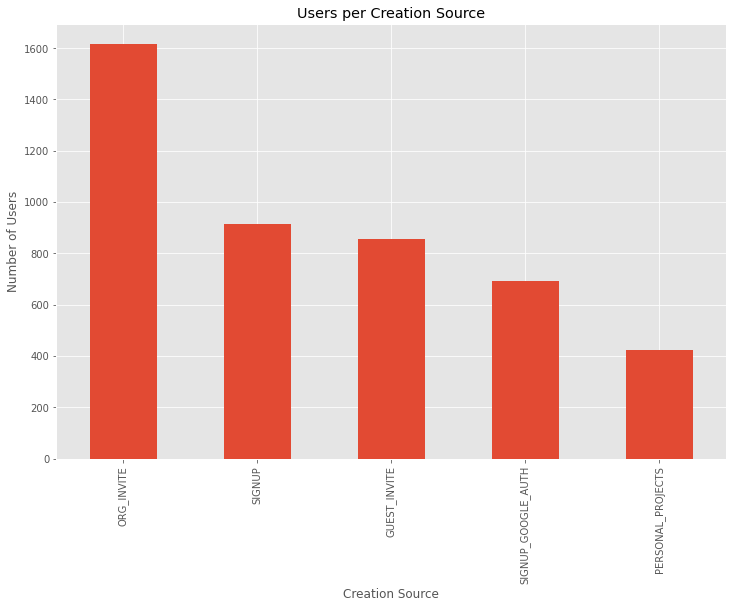

In [40]:

# plot of user per creation source
df_ml5['creation_source'].value_counts().plot(kind='bar', figsize=(12,8), title='Users per Creation Source')
plt.xlabel('Creation Source')
plt.ylabel('Number of Users')
plt.show()

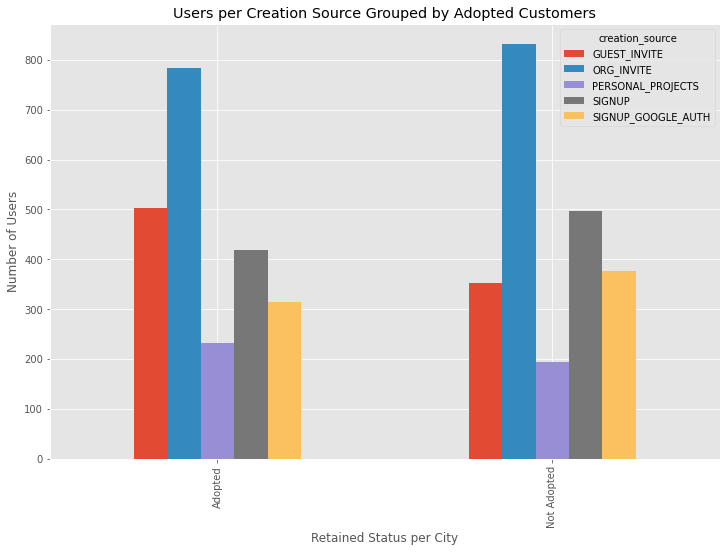

In [41]:
df_ml5.groupby('adopted_string')['creation_source'].value_counts().unstack().plot(kind='bar', figsize=(12,8), 
                                                                    title='Users per Creation Source Grouped by Adopted Customers')
plt.xlabel('Retained Status per City')
plt.ylabel('Number of Users')
plt.show()

gmail.com         1492
yahoo.com          839
hotmail.com        467
gustr.com          441
jourrapide.com     428
cuvox.de           395
xybhi.com            2
mumdc.com            2
luque.com            2
Name: domain, dtype: int64


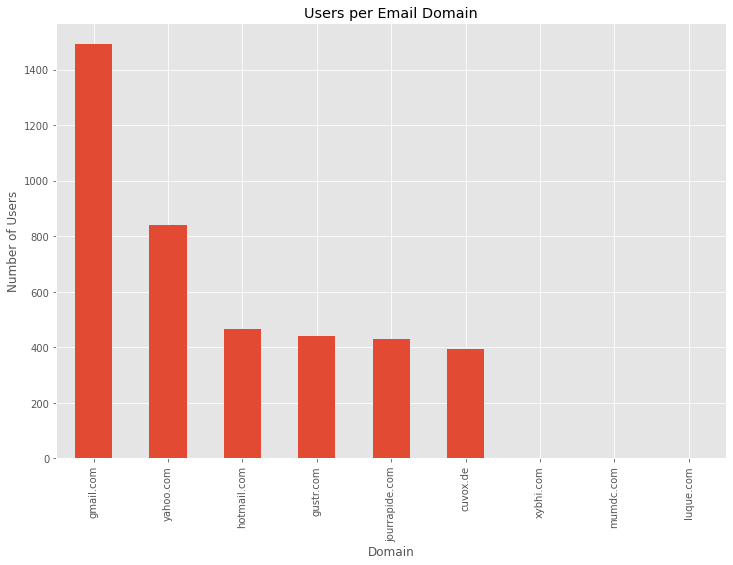

In [42]:
# plot of user per domain

#turns out that there are lots of unique domains, so we will filter first for domains with more than one user

temp_df_domains = df_ml5.groupby('domain').filter(lambda x: len(x) > 1)

print(temp_df_domains['domain'].value_counts())

temp_df_domains['domain'].value_counts().plot(kind='bar', figsize=(12,8), title='Users per Email Domain')
plt.xlabel('Domain')
plt.ylabel('Number of Users')
plt.show()

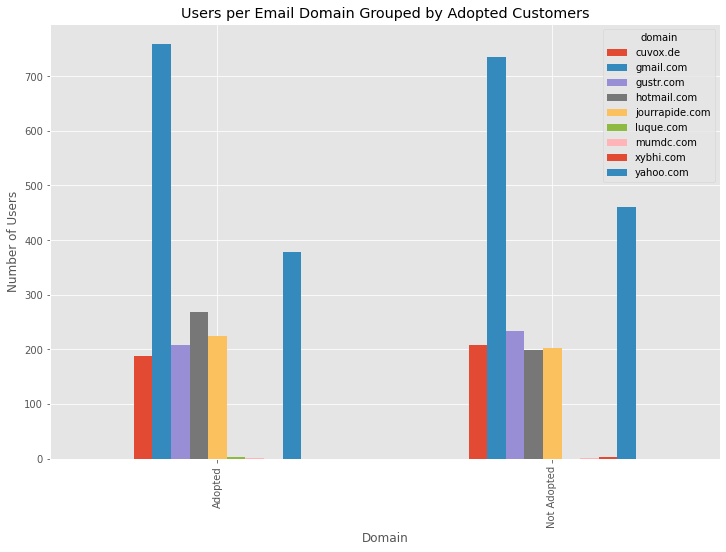

In [43]:
temp_df_domains.groupby('adopted_string')['domain'].value_counts().unstack().plot(kind='bar', figsize=(12,8), 
                                                                    title='Users per Email Domain Grouped by Adopted Customers')
plt.xlabel('Domain')
plt.ylabel('Number of Users')
plt.show()

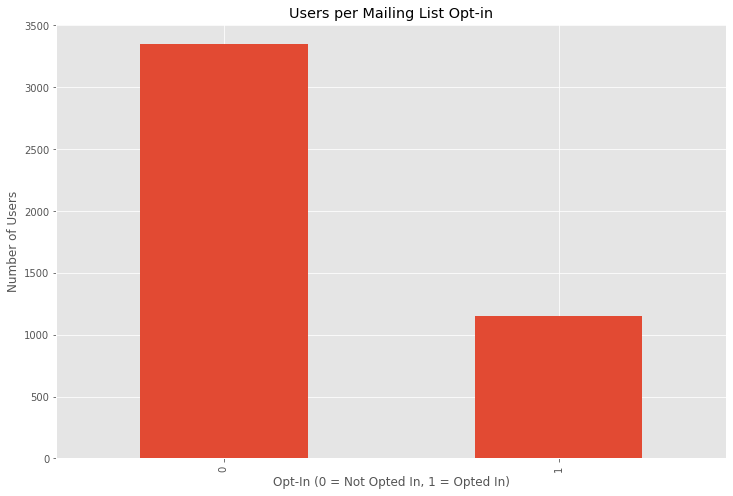

In [44]:
# plot of mailing list opt-ins

df_ml5['opted_in_to_mailing_list'].value_counts().plot(kind='bar', figsize=(12,8), title='Users per Mailing List Opt-in')
plt.xlabel('Opt-In (0 = Not Opted In, 1 = Opted In)')
plt.ylabel('Number of Users')
plt.show()

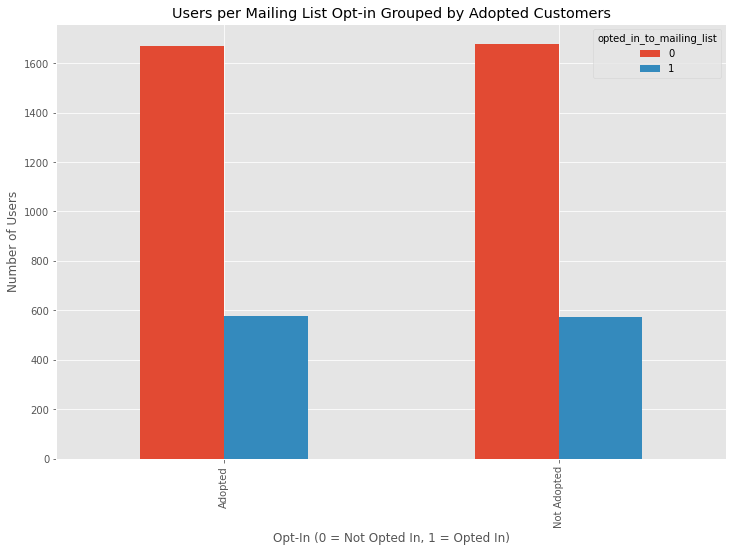

In [45]:
df_ml5.groupby('adopted_string')['opted_in_to_mailing_list'].value_counts().unstack().plot(kind='bar', figsize=(12,8), 
                                                                    title='Users per Mailing List Opt-in Grouped by Adopted Customers')
plt.xlabel('Opt-In (0 = Not Opted In, 1 = Opted In)')
plt.ylabel('Number of Users')
plt.show()

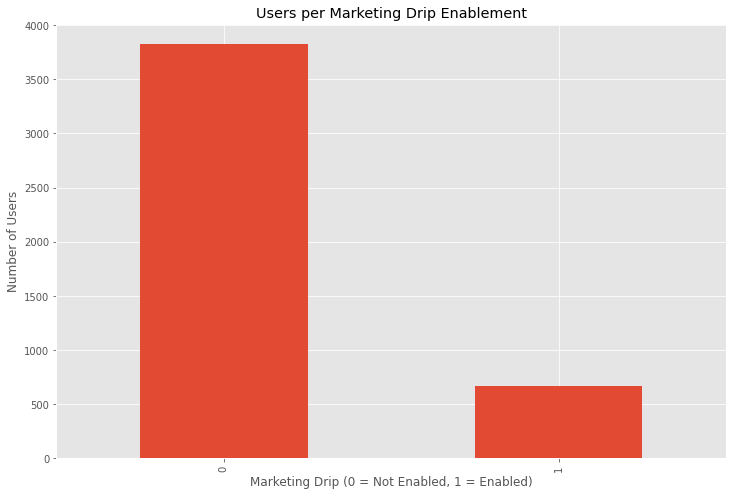

In [46]:
# plot of marketing drip

df_ml5['enabled_for_marketing_drip'].value_counts().plot(kind='bar', figsize=(12,8), title='Users per Marketing Drip Enablement')
plt.xlabel('Marketing Drip (0 = Not Enabled, 1 = Enabled)')
plt.ylabel('Number of Users')
plt.show()

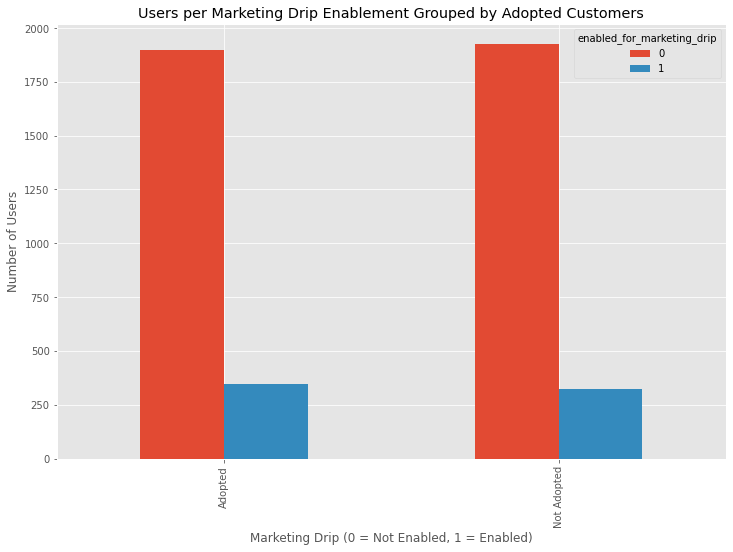

In [47]:
df_ml5.groupby('adopted_string')['enabled_for_marketing_drip'].value_counts().unstack().plot(kind='bar', figsize=(12,8), 
                                                                    title='Users per Marketing Drip Enablement Grouped by Adopted Customers')
plt.xlabel('Marketing Drip (0 = Not Enabled, 1 = Enabled)')
plt.ylabel('Number of Users')
plt.show()

0    94
1    65
4    56
2    56
9    49
7    44
3    40
Name: org_id, dtype: int64


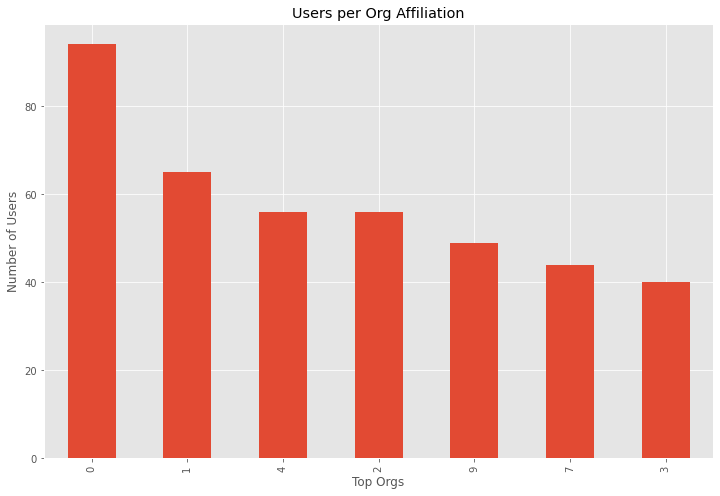

In [48]:
#plot of user org IDs

#there are 400+ orgs, so we will filter first for orgs with 40 or more users

temp_df_orgs = df_ml5.groupby('org_id').filter(lambda x: len(x) > 39)

print(temp_df_orgs['org_id'].value_counts())

temp_df_orgs['org_id'].value_counts().plot(kind='bar', figsize=(12,8), title='Users per Org Affiliation')
plt.xlabel('Top Orgs')
plt.ylabel('Number of Users')
plt.show()


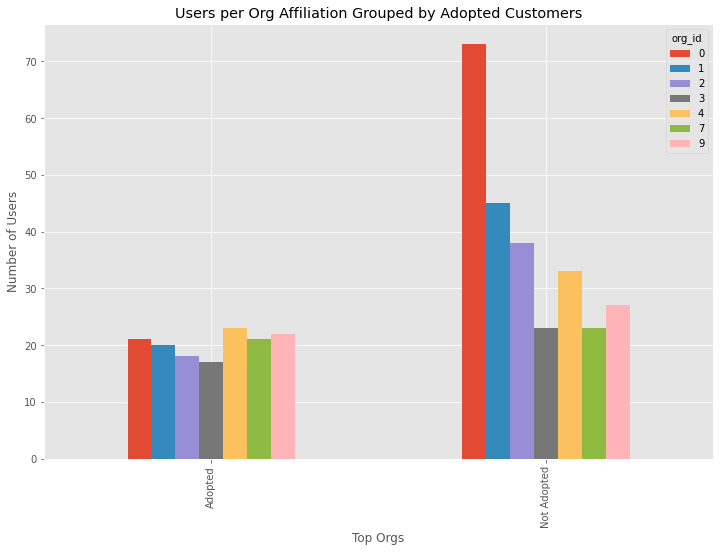

In [49]:
temp_df_orgs.groupby('adopted_string')['org_id'].value_counts().unstack().plot(kind='bar', figsize=(12,8), 
                                                                    title='Users per Org Affiliation Grouped by Adopted Customers')
plt.xlabel('Top Orgs')
plt.ylabel('Number of Users')
plt.show()

In [50]:
#not going to plot invited by category, but just from looking at the value counts, it looks like 1/2 of users 
#joined without invite from another user

#this might be worth including as a boolean column
df_ml5.invited_by_user_id.value_counts()

0.0        2028
10628.0       6
8026.0        6
121.0         6
1846.0        6
           ... 
3984.0        1
465.0         1
2608.0        1
909.0         1
8905.0        1
Name: invited_by_user_id, Length: 1554, dtype: int64

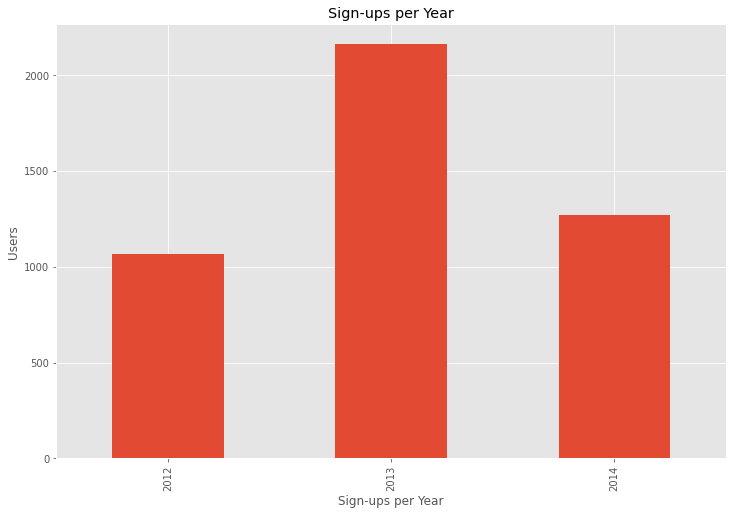

In [51]:
#plot of signup years

df['creation_year'].value_counts().loc[[2012, 2013, 2014]].plot(kind='bar', figsize=(12,8), 
                                                                     title='Sign-ups per Year')

plt.xlabel('Sign-ups per Year')
plt.ylabel('Users')
plt.show()

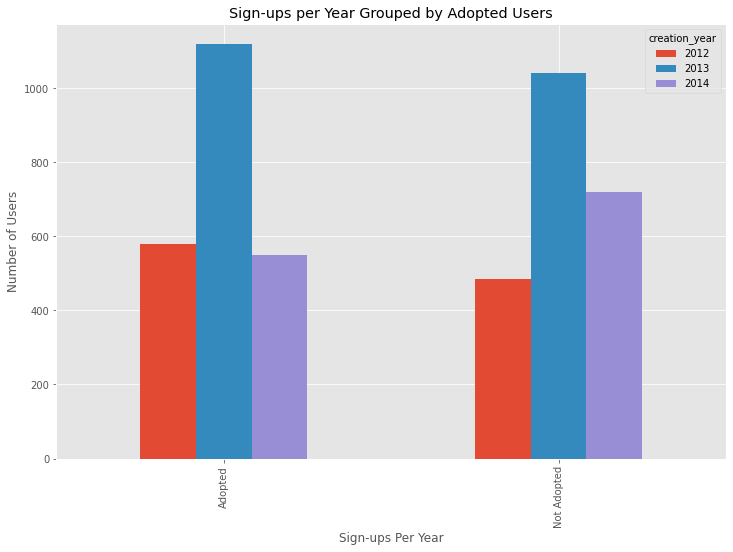

In [52]:
df.groupby('adopted_string')['creation_year'].value_counts().unstack().plot(kind='bar', figsize=(12,8), 
                                                                          title='Sign-ups per Year Grouped by Adopted Users')

plt.xlabel('Sign-ups Per Year')
plt.ylabel('Number of Users')
plt.show()

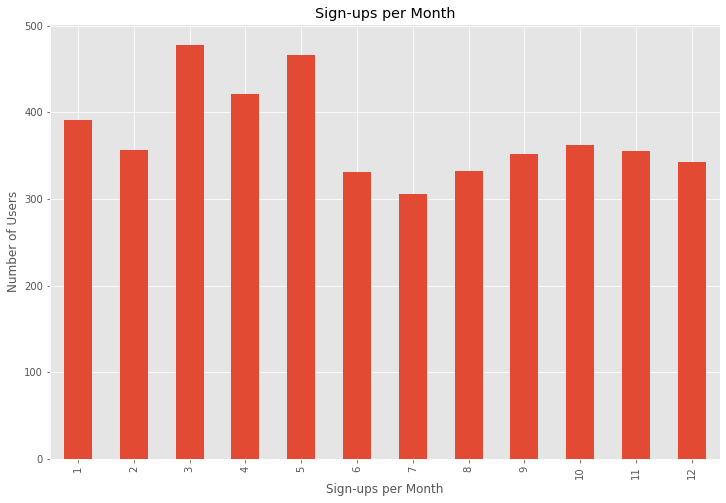

In [53]:
df['creation_month'].value_counts().loc[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
                                            11, 12]].plot(kind='bar', figsize=(12,8), 
                                                                     title='Sign-ups per Month')

plt.xlabel('Sign-ups per Month')
plt.ylabel('Number of Users')
plt.show()

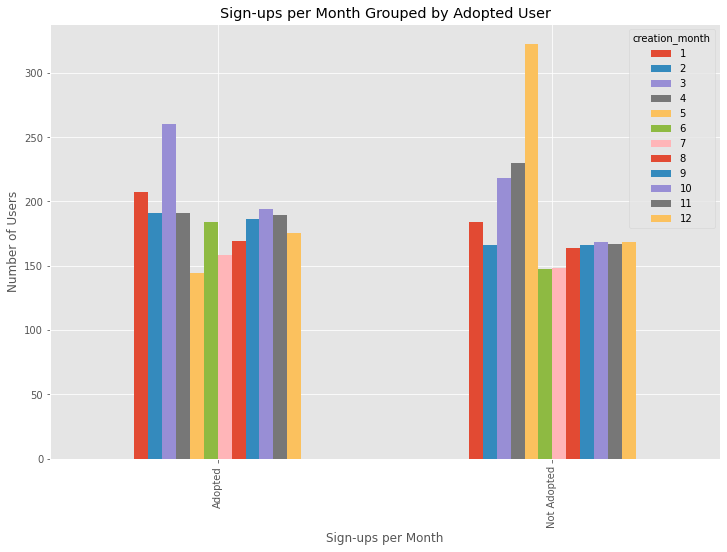

In [54]:
df.groupby('adopted_string')['creation_month'].value_counts().unstack().plot(kind='bar', figsize=(12,8), 
                                                                          title='Sign-ups per Month Grouped by Adopted User')

plt.xlabel('Sign-ups per Month')
plt.ylabel('Number of Users')
plt.show()

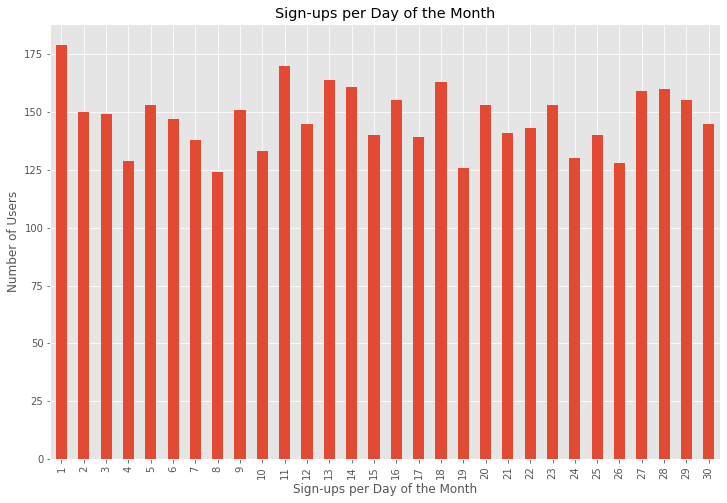

In [55]:
df['creation_day'].value_counts().loc[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
                                            11, 12, 13, 14, 15, 16, 17, 
                                      18, 19, 20, 21, 22, 23, 24, 25, 26,
                                      27, 28, 29, 30]].plot(kind='bar', figsize=(12,8), 
                                                                     title='Sign-ups per Day of the Month')

plt.xlabel('Sign-ups per Day of the Month')
plt.ylabel('Number of Users')
plt.show()

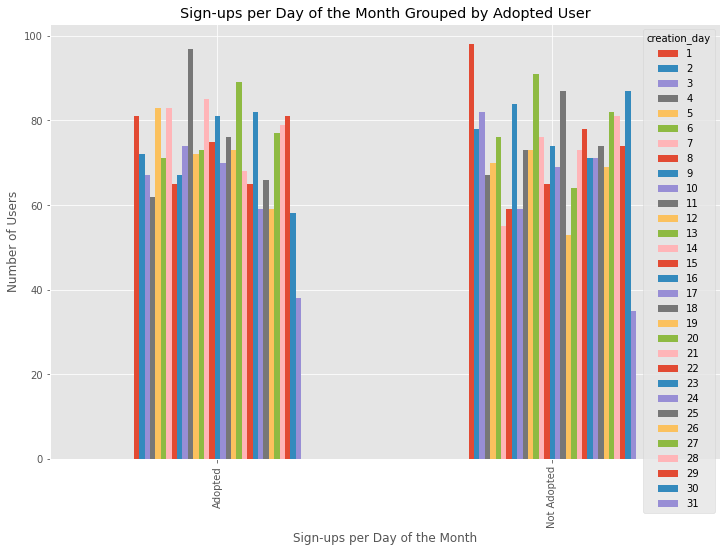

In [56]:
df.groupby('adopted_string')['creation_day'].value_counts().unstack().plot(kind='bar', figsize=(12,8), 
                                                                          title='Sign-ups per Day of the Month Grouped by Adopted User')

plt.xlabel('Sign-ups per Day of the Month')
plt.ylabel('Number of Users')
plt.show()

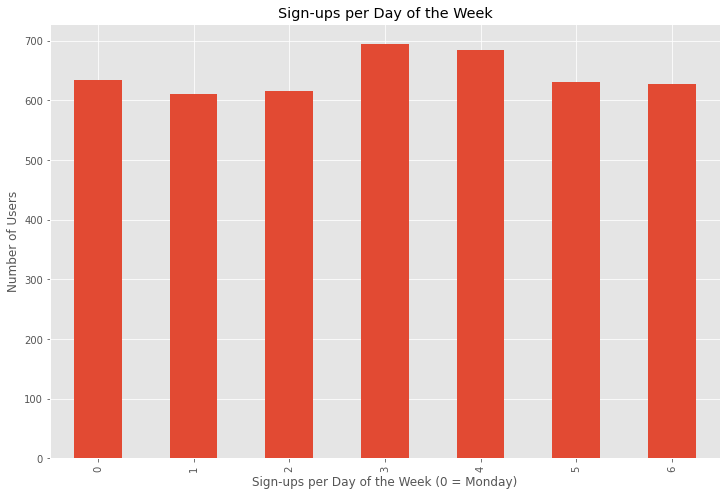

In [57]:
df['creation_dayofweek'].value_counts().loc[[0, 1, 2, 3, 4, 5, 6]].plot(kind='bar', figsize=(12,8), 
                                                                     title='Sign-ups per Day of the Week')

plt.xlabel('Sign-ups per Day of the Week (0 = Monday)')
plt.ylabel('Number of Users')
plt.show()

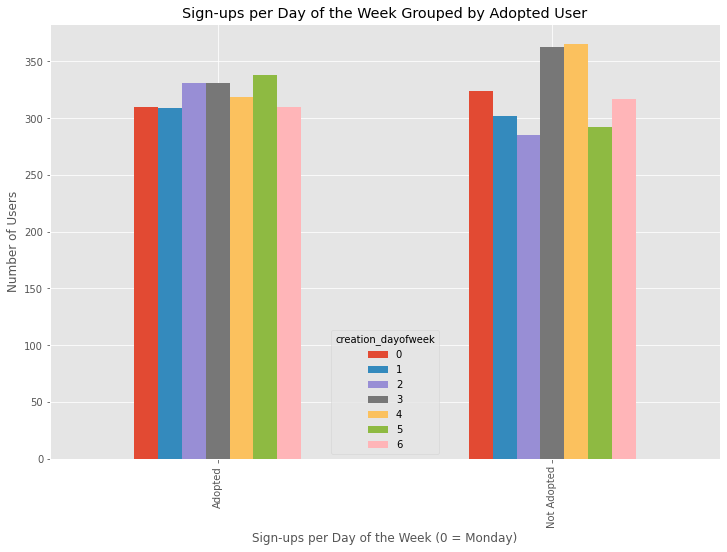

In [58]:
df.groupby('adopted_string')['creation_dayofweek'].value_counts().unstack().plot(kind='bar', figsize=(12,8), 
                                                                          title='Sign-ups per Day of the Week Grouped by Adopted User')

plt.xlabel('Sign-ups per Day of the Week (0 = Monday)')
plt.ylabel('Number of Users')
plt.show()

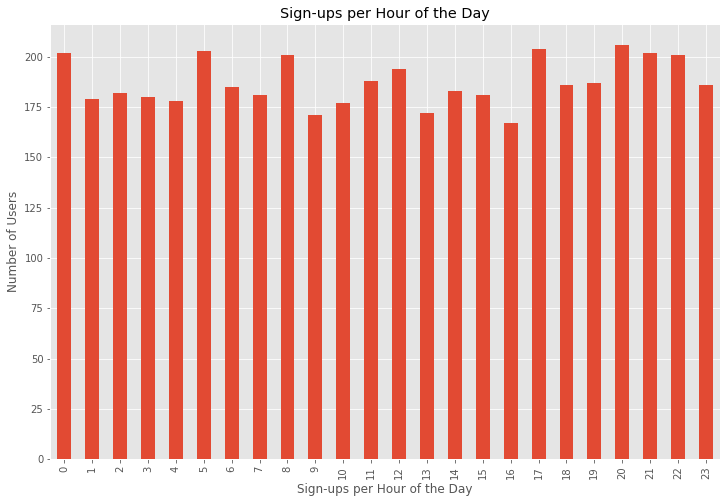

In [59]:
df['creation_hour'].value_counts().loc[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
                                            11, 12, 13, 14, 15, 16, 17, 
                                      18, 19, 20, 21, 22, 23]].plot(kind='bar', figsize=(12,8), 
                                                                     title='Sign-ups per Hour of the Day')

plt.xlabel('Sign-ups per Hour of the Day')
plt.ylabel('Number of Users')
plt.show()

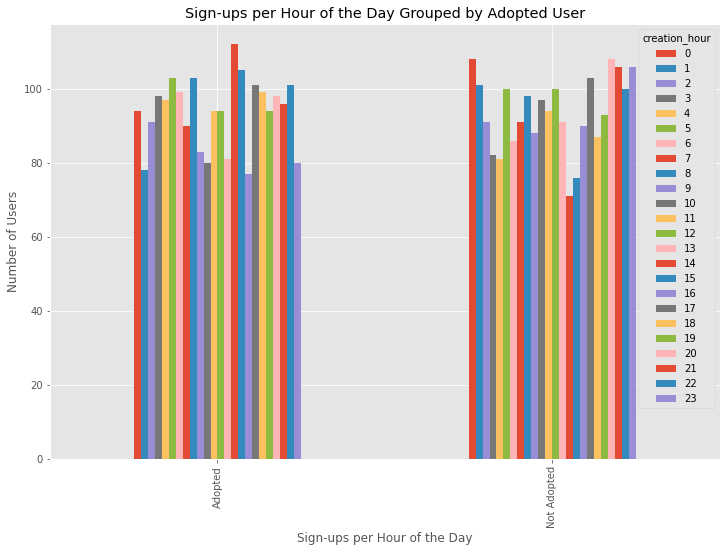

In [60]:
df.groupby('adopted_string')['creation_hour'].value_counts().unstack().plot(kind='bar', figsize=(12,8), 
                                                                          title='Sign-ups per Hour of the Day Grouped by Adopted User')

plt.xlabel('Sign-ups per Hour of the Day')
plt.ylabel('Number of Users')
plt.show()

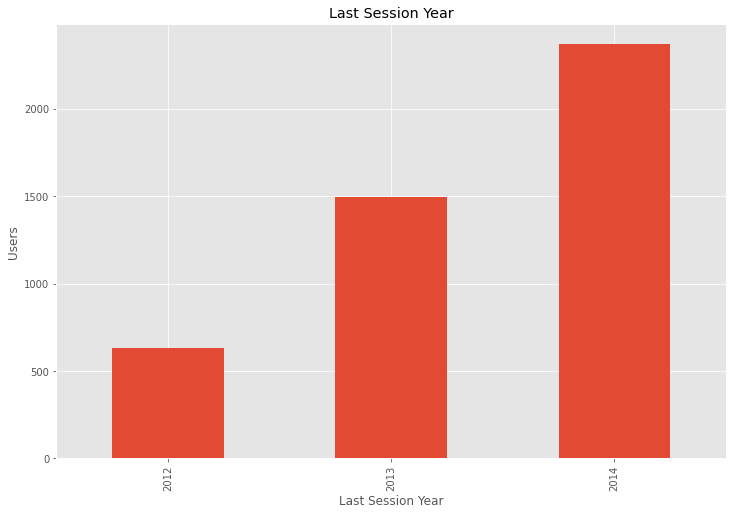

In [61]:
#plots of last sessions 

df['last_sess_year'].value_counts().loc[[2012, 2013, 2014]].plot(kind='bar', figsize=(12,8), 
                                                                     title='Last Session Year')

plt.xlabel('Last Session Year')
plt.ylabel('Users')
plt.show()

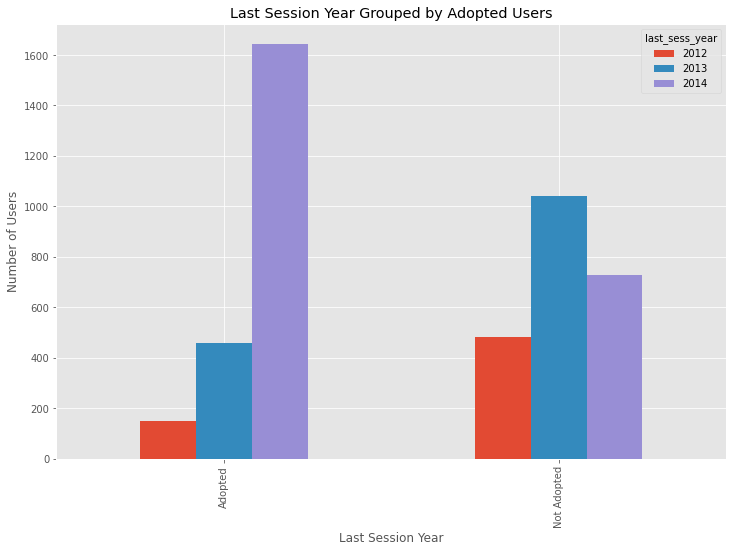

In [62]:
df.groupby('adopted_string')['last_sess_year'].value_counts().unstack().plot(kind='bar', figsize=(12,8), 
                                                                          title='Last Session Year Grouped by Adopted Users')

plt.xlabel('Last Session Year')
plt.ylabel('Number of Users')
plt.show()

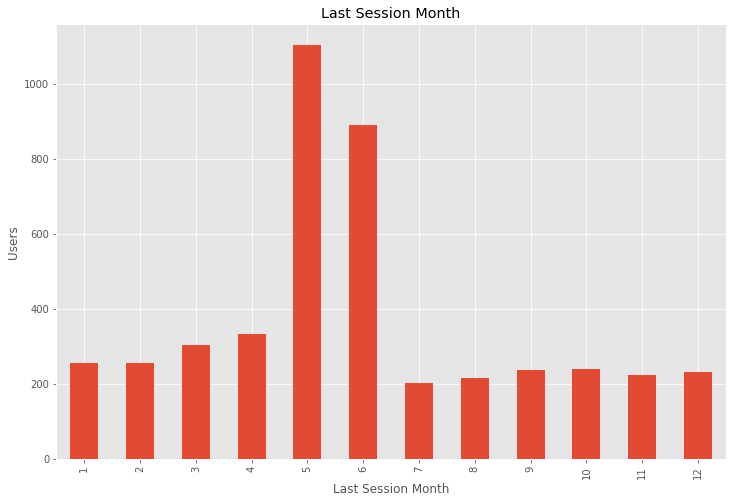

In [63]:


df['last_sess_month'].value_counts().loc[[1, 2, 3, 4, 5, 6, 7, 
                                         8, 9, 10, 11, 12]].plot(kind='bar', figsize=(12,8), 
                                                                     title='Last Session Month')

plt.xlabel('Last Session Month')
plt.ylabel('Users')
plt.show()

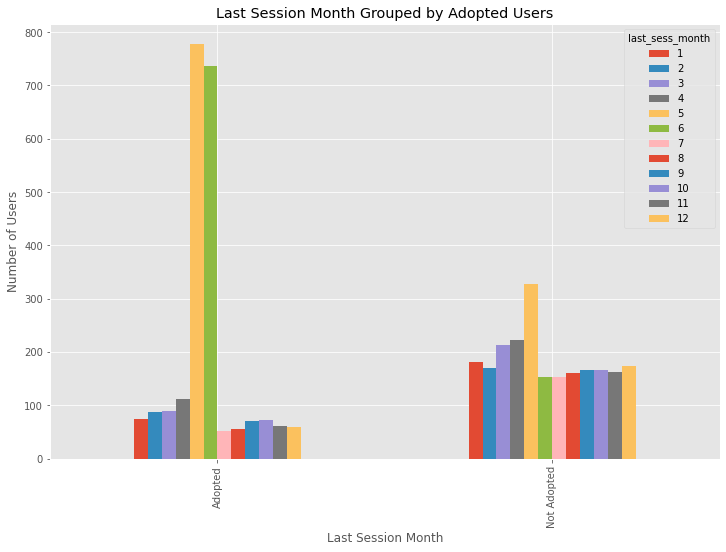

In [64]:
df.groupby('adopted_string')['last_sess_month'].value_counts().unstack().plot(kind='bar', figsize=(12,8), 
                                                                          title='Last Session Month Grouped by Adopted Users')

plt.xlabel('Last Session Month')
plt.ylabel('Number of Users')
plt.show()

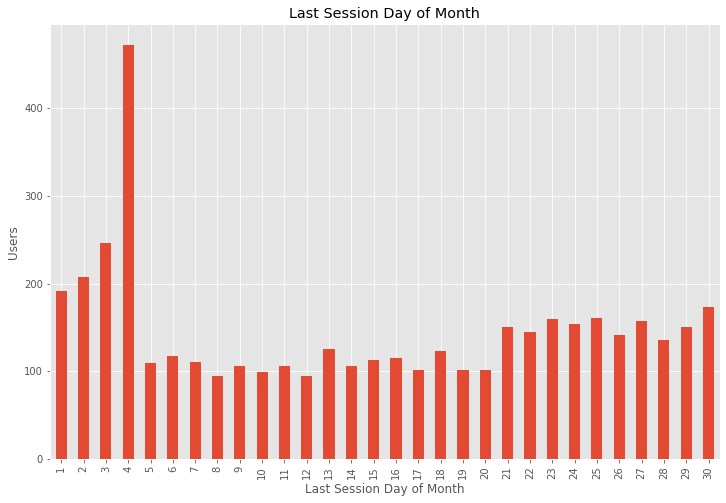

In [65]:


df['last_sess_day'].value_counts().loc[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
                                            11, 12, 13, 14, 15, 16, 17, 18, 
                                            19, 20, 21, 22, 23, 24, 25, 26,
                                            27, 28, 29, 30]].plot(kind='bar', figsize=(12,8), 
                                                                     title='Last Session Day of Month')

plt.xlabel('Last Session Day of Month')
plt.ylabel('Users')
plt.show()

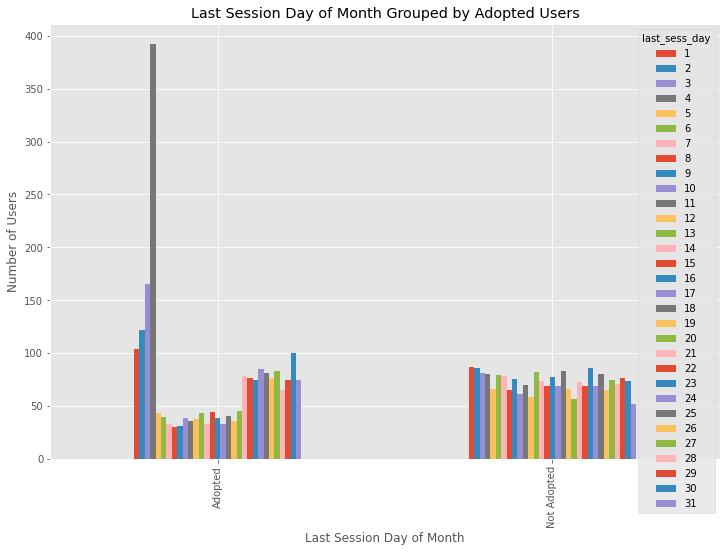

In [66]:
df.groupby('adopted_string')['last_sess_day'].value_counts().unstack().plot(kind='bar', figsize=(12,8), 
                                                                          title='Last Session Day of Month Grouped by Adopted Users')

plt.xlabel('Last Session Day of Month')
plt.ylabel('Number of Users')
plt.show()

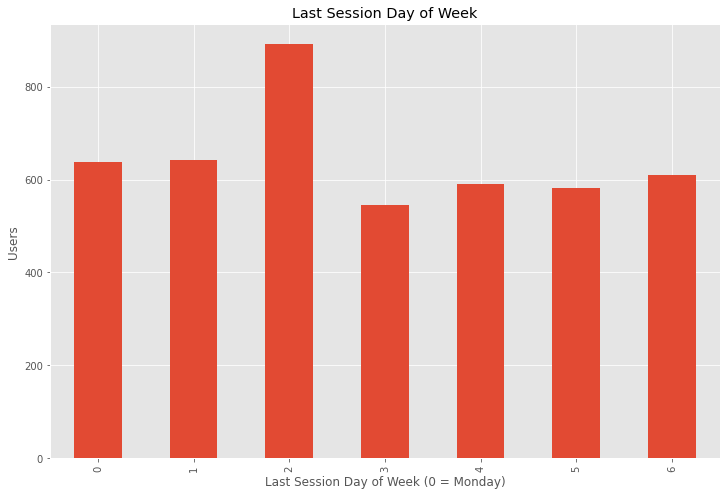

In [67]:
#plot of signup years

df['last_sess_dayofweek'].value_counts().loc[[0, 1, 2, 3, 4, 5, 6]].plot(kind='bar', figsize=(12,8), 
                                                                     title='Last Session Day of Week')

plt.xlabel('Last Session Day of Week (0 = Monday)')
plt.ylabel('Users')
plt.show()

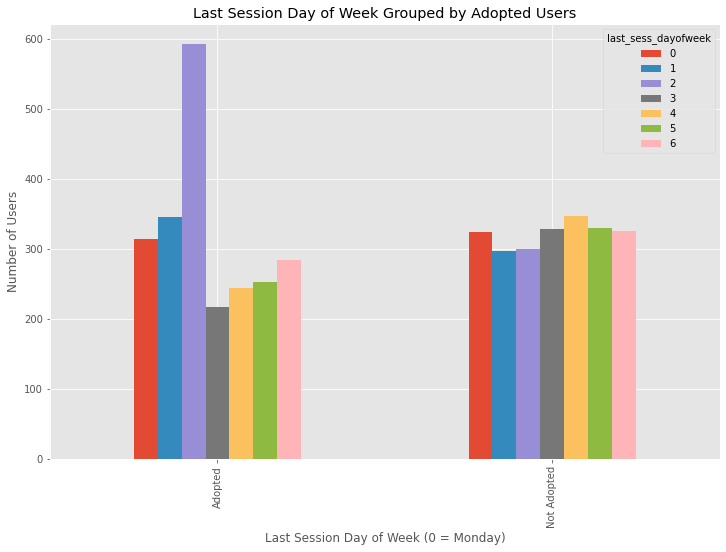

In [68]:
df.groupby('adopted_string')['last_sess_dayofweek'].value_counts().unstack().plot(kind='bar', figsize=(12,8), 
                                                                          title='Last Session Day of Week Grouped by Adopted Users')

plt.xlabel('Last Session Day of Week (0 = Monday)')
plt.ylabel('Number of Users')
plt.show()

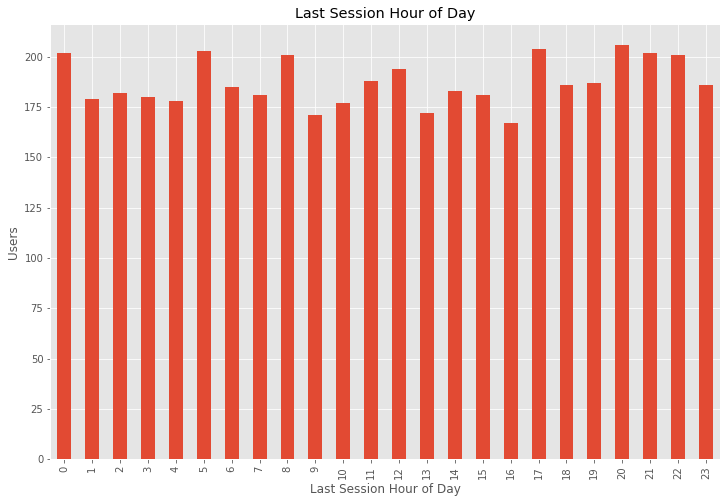

In [69]:


df['last_sess_hour'].value_counts().loc[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
                                            11, 12, 13, 14, 15, 16, 17, 18, 
                                            19, 20, 21, 22, 23]].plot(kind='bar', figsize=(12,8), 
                                                                     title='Last Session Hour of Day')

plt.xlabel('Last Session Hour of Day')
plt.ylabel('Users')
plt.show()

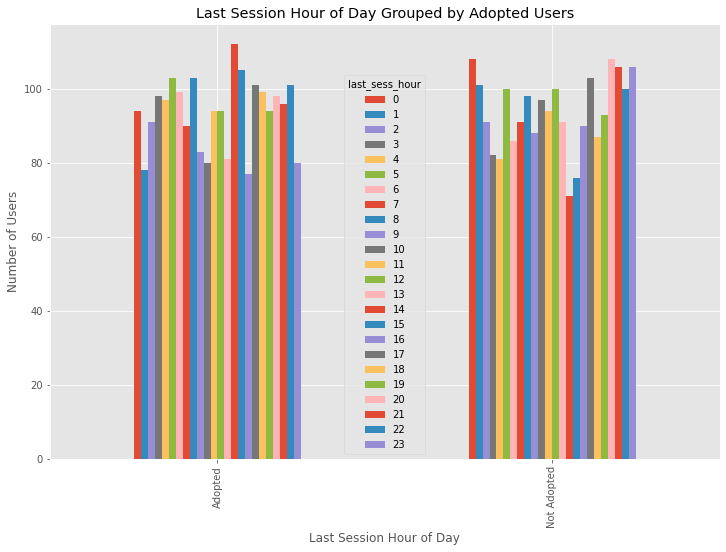

In [70]:
df.groupby('adopted_string')['last_sess_hour'].value_counts().unstack().plot(kind='bar', figsize=(12,8), 
                                                                          title='Last Session Hour of Day Grouped by Adopted Users')

plt.xlabel('Last Session Hour of Day')
plt.ylabel('Number of Users')
plt.show()

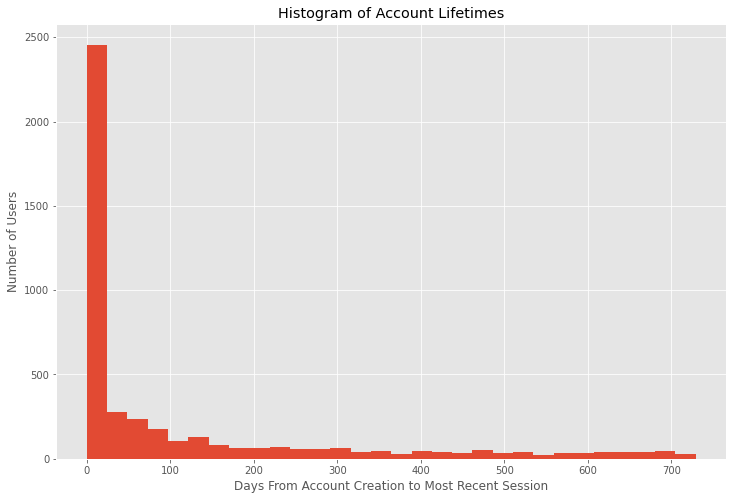

In [71]:
#member days histogram

df['member_days'].hist(bins=30, figsize=(12,8))
#plt.yscale('log')
plt.title('Histogram of Account Lifetimes')
plt.xlabel('Days From Account Creation to Most Recent Session')
plt.ylabel('Number of Users')
plt.show()



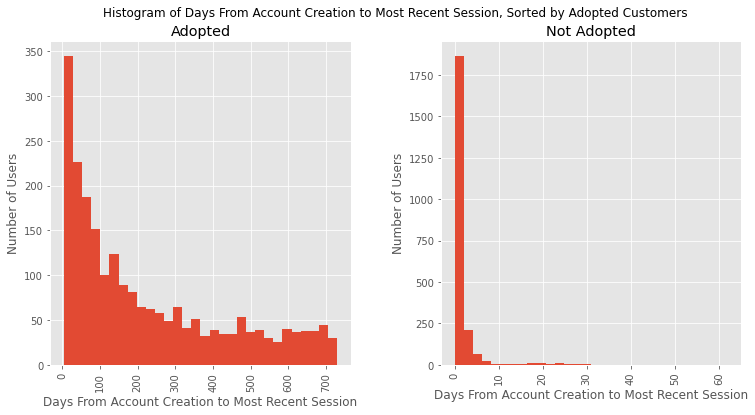

In [72]:
axes = df['member_days'].hist(by=df['adopted_string'], bins=30, figsize=(12,6))
plt.suptitle('Histogram of Days From Account Creation to Most Recent Session, Sorted by Adopted Customers')
#plt.yscale('log')
for ax in axes.flatten():
    ax.set_xlabel("Days From Account Creation to Most Recent Session")
    ax.set_ylabel("Number of Users")
plt.show()

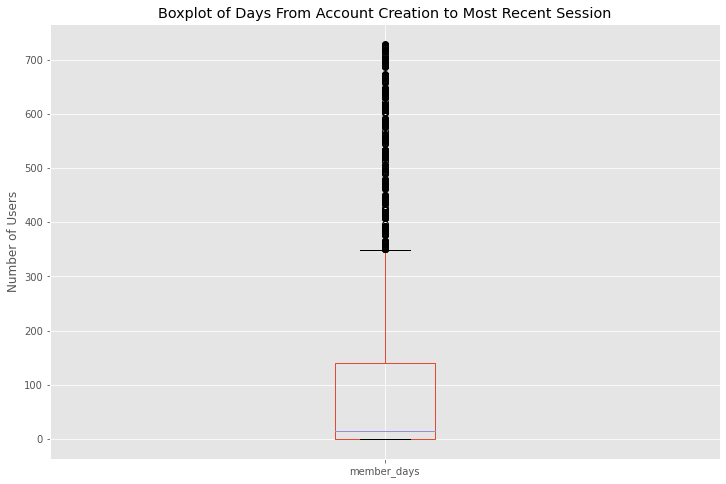

In [73]:
df.boxplot(column='member_days', figsize=(12,8))
#.set_yscale('log')
plt.title('Boxplot of Days From Account Creation to Most Recent Session')
#plt.xlabel('Number of Trips')
plt.ylabel('Number of Users')
plt.show()

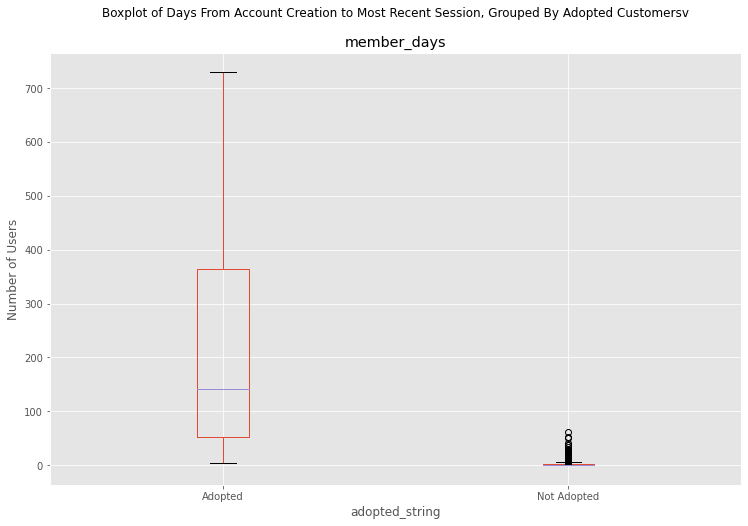

In [74]:
# here is the most interesting plot!!

df.boxplot(column='member_days', by='adopted_string', figsize=(12,8))
#.set_yscale('log')
plt.suptitle("Boxplot of Days From Account Creation to Most Recent Session, Grouped By Adopted Customersv")
plt.ylabel('Number of Users')
plt.show()

The above boxplot is probably our most significant graph. We can see a huge difference in the behavior of adopted and non-adopted users, with adopted users having a much longer account life than non-adopted users. Note that date of last login, or number of days between account creation and last login, in theory should tell us nothing about whether the user met the criteria of logging in at least 3 times within any 7-day period. For all we know, a user with an account lifespan of 200 days could have only logged in once a week, in which case they would not be considered adopted.

In [75]:
#check df once more
df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,member_days,creation_year,creation_month,creation_day,creation_dayofweek,...,domain_yyyxt.com,domain_yyzci.com,domain_zfbno.com,domain_zghrn.com,domain_zjwjb.com,domain_zkcep.com,domain_zkdih.com,domain_zpbkw.com,domain_zssin.com,adopted_string
0,0,0,1,316.0,1,136.0,2013,11,15,4,...,0,0,0,0,0,0,0,0,0,Adopted
1,1,1,318,4143.0,1,503.0,2013,1,16,2,...,0,0,0,0,0,0,0,0,0,Adopted
2,0,0,58,0.0,1,84.0,2014,3,6,3,...,0,0,0,0,0,0,0,0,0,Adopted
3,0,0,401,79.0,1,81.0,2014,3,11,1,...,0,0,0,0,0,0,0,0,0,Adopted
4,1,0,235,0.0,1,560.0,2012,11,11,6,...,0,0,0,0,0,0,0,0,0,Adopted


In [76]:
#drop string column for predictive modeling
df1 = df.drop('adopted_string', 1)

#add boolean column for invited/not invited
df1['invited'] = [1 if x > 0 else 0 for x in df1['invited_by_user_id']] 

df1.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,member_days,creation_year,creation_month,creation_day,creation_dayofweek,...,domain_yyyxt.com,domain_yyzci.com,domain_zfbno.com,domain_zghrn.com,domain_zjwjb.com,domain_zkcep.com,domain_zkdih.com,domain_zpbkw.com,domain_zssin.com,invited
0,0,0,1,316.0,1,136.0,2013,11,15,4,...,0,0,0,0,0,0,0,0,0,1
1,1,1,318,4143.0,1,503.0,2013,1,16,2,...,0,0,0,0,0,0,0,0,0,1
2,0,0,58,0.0,1,84.0,2014,3,6,3,...,0,0,0,0,0,0,0,0,0,0
3,0,0,401,79.0,1,81.0,2014,3,11,1,...,0,0,0,0,0,0,0,0,0,1
4,1,0,235,0.0,1,560.0,2012,11,11,6,...,0,0,0,0,0,0,0,0,0,0


## Predictive Modeling

We are now ready to test some models. After importing the relevant packages, We can split the data into training and testing sets. Our target column for prediction is the adopted column. Then the first model to test is Linear SVC, since the number of samples is relatively small. We will also look at a few other models for comparison. All hyperparameters are tuned using a grid search, and complete metrics are printed out. In addition, plots and charts of feature importances are provided.

In [77]:
#machine learning set up
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import scale
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.svm import LinearSVC

print('done')

done


In [78]:
#shuffle data before splitting (right now it is all adopted rows stacked on all not adopted rows)

df2 = df1.sample(frac=1).reset_index(drop=True)
df2.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,member_days,creation_year,creation_month,creation_day,creation_dayofweek,...,domain_yyyxt.com,domain_yyzci.com,domain_zfbno.com,domain_zghrn.com,domain_zjwjb.com,domain_zkcep.com,domain_zkdih.com,domain_zpbkw.com,domain_zssin.com,invited
0,0,0,0,0.0,0,1.0,2012,11,5,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,319,7442.0,0,0.0,2014,3,24,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,163,1175.0,1,26.0,2013,5,25,5,...,0,0,0,0,0,0,0,0,0,1
3,1,1,147,7196.0,1,54.0,2012,12,12,2,...,0,0,0,0,0,0,0,0,0,1
4,0,0,211,0.0,1,560.0,2012,11,7,2,...,0,0,0,0,0,0,0,0,0,0


In [79]:

#split into training and target
X = df2.drop(['adopted'], axis=1)
y = df2['adopted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(len(X_train))
print(len(X_test))

3596
900


In [80]:
#try also Linear SVC as recommended by Sklearn flowchart, since the sample size is rather small

from sklearn.svm import LinearSVC

#functions to tune linear svc

def performance_metric_accuracy(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = accuracy_score(y_true, y_predict)
    
    # Return the score
    return score

def fit_model(X, y):
 
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits=5, test_size=0.20, random_state=0)

    #  Create a logistic regression object
    regressor = LinearSVC()

    #  Create a dictionary for the parameters 
    params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    
    #  Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric_accuracy)

    #  Create the grid search object
    grid = GridSearchCV(regressor, params, scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_


In [81]:
#find hyperparameters for Linear SVC

svc_result = fit_model(X_train, y_train)
print(svc_result)

LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


In [82]:
#predict with Linear SVC

#instantiate the classifier
svc = LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

# Fit the model on the training data.
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

# accuracy score for training
train_accuracy = svc.score(X_train, y_train)

# accuracy score for test set
test_accuracy = svc.score(X_test, y_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

print("Training set score is {}".format(train_accuracy))
print("Test set score is {}".format(test_accuracy))
print('ROC AUC is {}'.format(roc_auc))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training set score is 0.9655172413793104
Test set score is 0.9644444444444444
ROC AUC is 0.9646868079721607
[[424  12]
 [ 20 444]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       436
           1       0.97      0.96      0.97       464

    accuracy                           0.96       900
   macro avg       0.96      0.96      0.96       900
weighted avg       0.96      0.96      0.96       900



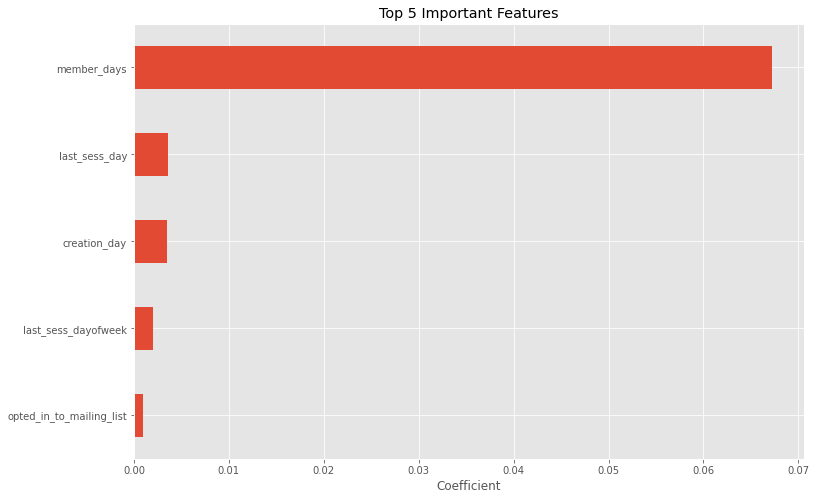

In [87]:
#plot linear svc coefficients for feature importances

pd.Series(abs(svc.coef_[0]), index=X.columns).nlargest(5).sort_values(ascending=True).plot(kind='barh', figsize=(12,8))
plt.title("Top 5 Important Features")
plt.xlabel("Coefficient")
plt.show()

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: -0.00011
Feature: 3, Score: -0.00078
Feature: 4, Score: 0.46902
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00006
Feature: 7, Score: 0.00072
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00056
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000


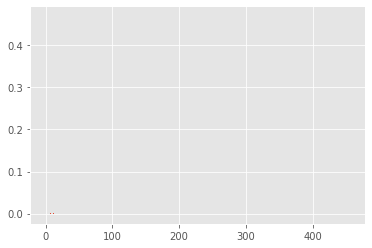

In [88]:
#We can also try permutation importance for linear svc
#permutation importances tests model performance over several iterations. During each iteration, data in a column is
#permuted (randomly resorted, basically changed to noise), and the performance in compared to the intact model.
#In short, it test which features contributed to model performance the most

# perform permutation importance
perm_importance = permutation_importance(svc, X_train, y_train, scoring='accuracy')
# get importance
importance = perm_importance.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

#feature 4 with .46 importance is member_days
#feature 3 is invited_by_user_id
#feature 2 is org_id

In [89]:
#try decision tree because data does not have normal distributions

#functions for hyperparameter tuning

def performance_metric_accuracy(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = accuracy_score(y_true, y_predict)
    
    # Return the score
    return score

def fit_model(X, y):
 
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits=5, test_size=0.20, random_state=0)

    #  Create a logistic regression object
    regressor = DecisionTreeClassifier()

    #  Create a dictionary for the parameters 
    params = {'max_features': [None, 'sqrt'], 'min_samples_split': [6, 8, 9, 10, 11, 12], 'max_depth': [4, 5, 6, 7, 8, 9, 10], 
              'splitter': ['best', 'random']}
    
    #  Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric_accuracy)

    #  Create the grid search object
    grid = GridSearchCV(regressor, params, scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [90]:
#find optimal hyperparameters

dt_result = fit_model(X_train, y_train)
print(dt_result)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [91]:
#predict with decision tree

#instantiate the classifier
decTree = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

# Fit the model on the training data.
decTree.fit(X_train, y_train)

y_pred = decTree.predict(X_test)

# accuracy score for training
train_accuracy = decTree.score(X_train, y_train)

# accuracy score for test set
test_accuracy = decTree.score(X_test, y_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

print("Training set score is {}".format(train_accuracy))
print("Test set score is {}".format(test_accuracy))
print('ROC AUC is {}'.format(roc_auc))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training set score is 0.9802558398220245
Test set score is 0.9733333333333334
ROC AUC is 0.9728230781398292
[[417  19]
 [  5 459]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       436
           1       0.96      0.99      0.97       464

    accuracy                           0.97       900
   macro avg       0.97      0.97      0.97       900
weighted avg       0.97      0.97      0.97       900



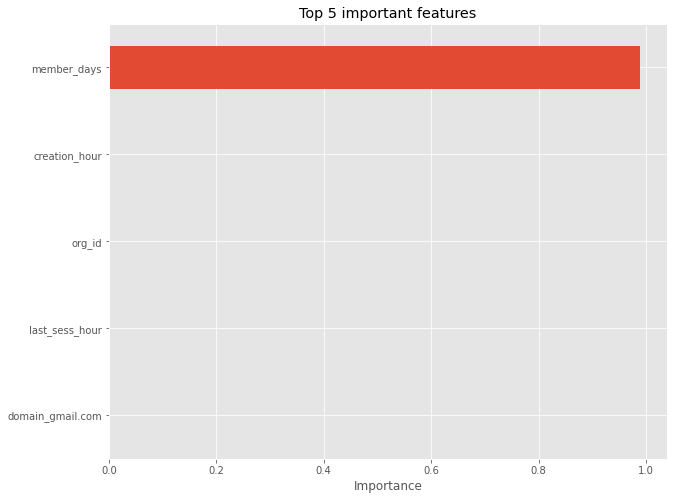

In [92]:
#plot feature importances

feat_importances = pd.Series(decTree.feature_importances_, index=X.columns)
feat_importances.nlargest(5).sort_values(ascending=True).plot(kind='barh', figsize=(10,8))
plt.title("Top 5 important features")
plt.xlabel("Importance")
plt.show()

In [93]:
#dataframe of feature importances
df_feat_importances = pd.DataFrame(decTree.feature_importances_, index = X.columns, 
                                             columns=['importance']).sort_values('importance', 
                                                                                 ascending=False)
df_feat_importances.head(10)

,importance
member_days,0.989377
creation_hour,0.001961
org_id,0.001916
last_sess_hour,0.001774
domain_gmail.com,0.001452
creation_year,0.001220
invited_by_user_id,0.001203
creation_day,0.001068
last_sess_day,0.000027
opted_in_to_mailing_list,0.000000


In [94]:
#try random forest model

#functions for hyperparameter tuning

def performance_metric_accuracy(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = accuracy_score(y_true, y_predict)
    
    # Return the score
    return score

def fit_model(X, y):
 
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits=5, test_size=0.20, random_state=0)

    #  Create a logistic regression object
    regressor = RandomForestClassifier()

    #  Create a dictionary for the parameters 
    params = {'n_estimators': [20, 25, 30], 'max_samples': [0.1, 0.2, 0.3, 0.4], 'max_features': [3, 4, 5, 6, 7]}
    
#     {'max_depth': [7, 10, 12, 15], 'min_samples_split': [6, 10, 15], 'n_estimators': [10, 20, 30], 
#               'max_samples': [0.1, 0.2, 0.3, 0.4], 'max_features': [3, 5, 7]}
    
    #  Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric_accuracy)

    #  Create the grid search object
    grid = GridSearchCV(regressor, params, scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [95]:
#optimize hyperparameters

rf_result = fit_model(X_train, y_train)
print(rf_result)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=5,
                       max_leaf_nodes=None, max_samples=0.4,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [96]:
#predict with random forest

#instantiate the classifier
rf1 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=5,
                       max_leaf_nodes=None, max_samples=0.4,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Fit the model on the training data.
rf1.fit(X_train, y_train)

y_pred = rf1.predict(X_test)

# accuracy score for training
train_accuracy = rf1.score(X_train, y_train)

# accuracy score for test set
test_accuracy = rf1.score(X_test, y_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

print("Training set score is {}".format(train_accuracy))
print("Test set score is {}".format(test_accuracy))
print('ROC AUC is {}'.format(roc_auc))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training set score is 0.9922135706340378
Test set score is 0.9488888888888889
ROC AUC is 0.9489777760202468
[[415  21]
 [ 25 439]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       436
           1       0.95      0.95      0.95       464

    accuracy                           0.95       900
   macro avg       0.95      0.95      0.95       900
weighted avg       0.95      0.95      0.95       900



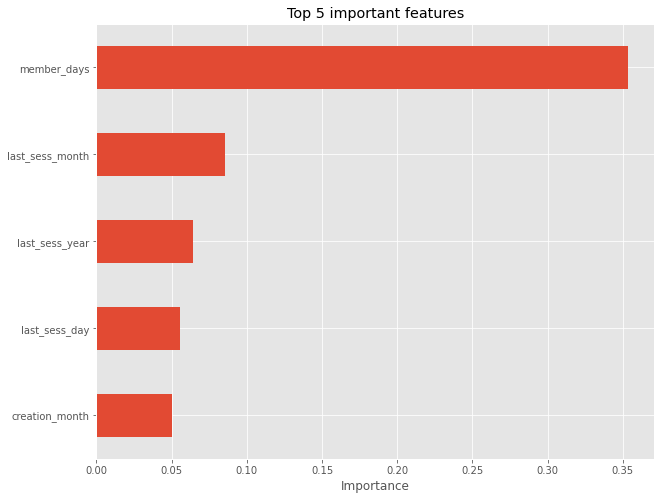

In [97]:
#plot feature importances for random forest

feat_importances = pd.Series(rf1.feature_importances_, index=X.columns)
feat_importances.nlargest(5).sort_values(ascending=True).plot(kind='barh', figsize=(10,8))
plt.title("Top 5 important features")
plt.xlabel("Importance")
plt.show()

In [98]:
#dataframe of feature importances
df_feat_importances = pd.DataFrame(rf1.feature_importances_, index = X.columns, 
                                             columns=['importance']).sort_values('importance', 
                                                                                 ascending=False)
df_feat_importances.head(10)

,importance
member_days,0.353404
last_sess_month,0.085399
last_sess_year,0.064010
last_sess_day,0.055357
creation_month,0.050256
org_id,0.049014
creation_day,0.047020
last_sess_hour,0.037300
creation_hour,0.037253
last_sess_dayofweek,0.036575


In [99]:
df2.groupby('adopted')['member_days'].mean()

adopted
0      1.875445
1    227.117883
Name: member_days, dtype: float64

In [104]:
#check balances of classes in training testing sets
print(len(y_train.loc[y_train == 0]))
print(len(y_train.loc[y_train == 1]))
print(len(y_test.loc[y_test == 0]))
print(len(y_test.loc[y_test == 1]))

#0 class in train
print(len(y_train.loc[y_train == 0])/3596*100)

#0 class in test
print(len(y_test.loc[y_test == 0])/900*100)

1812
1784
436
464
50.38932146829811
48.44444444444444


In [105]:
#try knn 

#functions to tune knn

def performance_metric_accuracy(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = accuracy_score(y_true, y_predict)
    
    # Return the score
    return score

def fit_model(X, y):
 
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits=5, test_size=0.20, random_state=0)

    #  Create a logistic regression object
    regressor = KNeighborsClassifier()

    #  Create a dictionary for the parameters 
    params = {'n_neighbors': [3, 5, 7, 10, 12, 15]}
    
    #  Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric_accuracy)

    #  Create the grid search object
    grid = GridSearchCV(regressor, params, scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [106]:
#find hyperparameters for knn

knn_result = fit_model(X_train, y_train)
print(knn_result)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


In [107]:
#predict with knn

#instantiate the classifier
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

# Fit the model on the training data.
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

# accuracy score for training
train_accuracy = knn.score(X_train, y_train)

# accuracy score for test set
test_accuracy = knn.score(X_test, y_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

print("Training set score is {}".format(train_accuracy))
print("Test set score is {}".format(test_accuracy))
print('ROC AUC is {}'.format(roc_auc))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training set score is 0.9204671857619577
Test set score is 0.8777777777777778
ROC AUC is 0.8795970420752925
[[409  27]
 [ 83 381]]
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       436
           1       0.93      0.82      0.87       464

    accuracy                           0.88       900
   macro avg       0.88      0.88      0.88       900
weighted avg       0.88      0.88      0.88       900



Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.02803
Feature: 3, Score: 0.03398
Feature: 4, Score: 0.38560
Feature: 5, Score: 0.00000
Feature: 6, Score: -0.00006
Feature: 7, Score: 0.00106
Feature: 8, Score: 0.00056
Feature: 9, Score: 0.00078
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00178
Feature: 13, Score: 0.00061
Feature: 14, Score: 0.00078
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
F

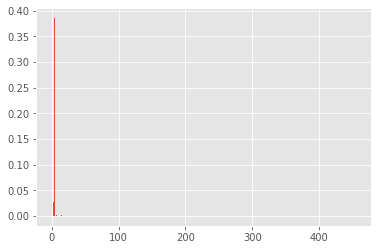

In [108]:
#feature importances cannot be easily obtained for knn. Instead we can use permutation importance
#permutation importances tests model performance over several iterations. During each iteration, data in a column is
#permuted (randomly resorted, basically changed to noise), and the performance in compared to the intact model.
#In short, it test which features contributed to model performance the most

# perform permutation importance
perm_importance = permutation_importance(knn, X_train, y_train, scoring='accuracy')
# get importance
importance = perm_importance.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

#feature 4 is member_days
#feature 3 is invited_by_user_id
#feature 2 is org_id

In [109]:
X.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,member_days,creation_year,creation_month,creation_day,creation_dayofweek,creation_hour,...,domain_yyyxt.com,domain_yyzci.com,domain_zfbno.com,domain_zghrn.com,domain_zjwjb.com,domain_zkcep.com,domain_zkdih.com,domain_zpbkw.com,domain_zssin.com,invited
0,0,0,0,0.0,1.0,2012,11,5,0,6,...,0,0,0,0,0,0,0,0,0,0
1,0,0,319,7442.0,0.0,2014,3,24,0,12,...,0,0,0,0,0,0,0,0,0,1
2,0,0,163,1175.0,26.0,2013,5,25,5,5,...,0,0,0,0,0,0,0,0,0,1
3,1,1,147,7196.0,54.0,2012,12,12,2,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,211,0.0,560.0,2012,11,7,2,16,...,0,0,0,0,0,0,0,0,0,0


## Conclusion

It seems like member days (number of days from account creation to most recent login date) is the most significant factor in determining whether a user will be adopted or not. While a greater number of days does not necessarily preclude that the user will have met the criteria of logging in three times in any given seven-day period during their time as an account holder, it appears to be the case that users who have longer account lives are more likely to fall into this category than, for example, users who create their account and then never log in again. We can see from the list of IDs pulled from the user engagement dataframe that these map onto the user dataframe in such a way that corresponds significantly with non-adopted users having little to no member lifespan.